In [1]:
import numpy as np
import qiskit
import mitiq
import matplotlib.pyplot as plt
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
from qiskit import *
from qiskit import IBMQ

This notebook applys mitiq to the Trotter circuit, as well as the built in measurement error mitigation methods provded by qiskit.

In [2]:
#Define the functions used to build the Trotter circuit.
def h_Z(qc,h,dt):
    for i in range(5):
        if i==0 or i==4:
            qc.rz(h*dt,i)
        else:
            qc.rz(2*h*dt,i)
        
def X_Rabi(qc,Omega,dt): # Rabi coupling
    
    for i in range(5):
        
        qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt): # nearest neighbor coupling
    
    qc.cx(0,1)
    
    qc.rz(-2*V*dt,1)
    
    qc.cx(0,1)
    
    qc.cx(2,3)
    
    qc.rz(-2*V*dt,3)
    
    qc.cx(2,3)
    
    qc.cx(1,2)
    
    qc.rz(-2*V*dt,2)
    
    qc.cx(1,2)
    
    qc.cx(3,4)
    
    qc.rz(-2*V*dt,4)
    
    qc.cx(3,4)

def Trotter_circuit_5_site(h,Omega,V,T,n):
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(5)
        
        ### Initial state setting
        
        Trotter_circuit.x(1)
        
        Trotter_circuit.x(3)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            X_Rabi(Trotter_circuit,Omega,dt) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt) # Z field 
            
            ZZ(Trotter_circuit,V,dt) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        Trotter_circuit.measure_all()
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [3]:
#Parameters used for the Trotter cirucit
Omega = 0.2*2

h = 2*2

V = 1*2

T = 10 # Total time

TT=T

#NEED TO CHECK IF THIS IS ALLOWED
delta_t = .5

#CHECK THIS AS WELL
n = int(np.rint(T/delta_t))

NN=n

Trotter_circuit = Trotter_circuit_5_site(h,Omega,V,T,n)

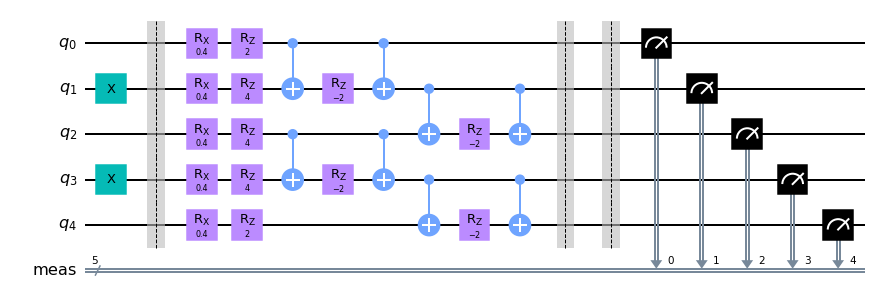

In [4]:
#See if the Trotter cirucit is correctly being built. Change x in Trotter_circuit[x] to see the cirucit
# for different time slices.
Trotter_circuit[1].draw(output='mpl')

We know we have the Trotter cirucit correctly set up, so we will run it without a noise model for now, giving us the ideal execution.

In [5]:
shots = 8192 #How many shots for the IDEAL execution

il = [0,1,2,3,4]

Trotter_circuit_sim_ideal = execute(Trotter_circuit, Aer.get_backend('qasm_simulator'), 
                              shots=shots, initial_layout=il)

ideal_result_sim = Trotter_circuit_sim_ideal.result()

In [6]:
#Get the simulated Z expectation values from the circuit
Sz_sim_ideal = []
for i in range(NN):
    tot_sim=np.zeros(5)
    Result_sim = ideal_result_sim.get_counts(i) 
    for j in range(2**5):
        n=2**5
        if j in Result_sim.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*Result_sim.int_outcomes()[j] 
    Sz_sim_ideal.append(tot_sim/shots)
Sz_sim_ideal=np.array(Sz_sim_ideal)

In [7]:
#Create lists for each qubit
q0_sim_list = []
q1_sim_list = []
q2_sim_list = []
q3_sim_list = []
q4_sim_list = []

#define our x axis for our graphs
t=np.linspace(0,TT,NN)

#put data in the lists
for x in range(0,len(Sz_sim_ideal)):
    q0_sim_list.append(Sz_sim_ideal[x,0])
    q1_sim_list.append(Sz_sim_ideal[x,1])
    q2_sim_list.append(Sz_sim_ideal[x,2])
    q3_sim_list.append(Sz_sim_ideal[x,3])
    q4_sim_list.append(Sz_sim_ideal[x,4])

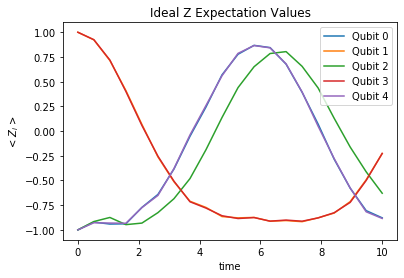

In [8]:
#Plot results for each qubit
fig,ax = plt.subplots()
ax.plot(t, q0_sim_list, label='Qubit 0')
ax.plot(t, q1_sim_list, label='Qubit 1')
ax.plot(t, q2_sim_list, label='Qubit 2')
ax.plot(t, q3_sim_list, label='Qubit 3')
ax.plot(t, q4_sim_list, label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('< $Z_i$ >')
ax.set_title("Ideal Z Expectation Values")
ax.legend()

Now that we have the ideal execution, we move on to simulating the noisy execution of our circuit, which will require mitiq, as well as the qiskit readout error mitigation.

In [9]:
#This cell sets up everythin we need so the readout error mitigation will work.
from qiskit.test.mock import FakeVigo

backend = FakeVigo()

#This needs to be 5, since we have 5 qubits in our circuit.
qr = QuantumRegister(5)

noise_model = NoiseModel.from_backend(backend)

qubit_list = [0,1,2,3,4]

meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

qasm_sim = Aer.get_backend('qasm_simulator')

t_qc = transpile(meas_calibs, backend) #Aer.get_backend('qasm_simulator'))
qobj = assemble(t_qc, shots=10000)

#note that the noise model isn't used until here. All the code in this cell above this comment is
# simply doing calibration of the circuit.
cal_results = qasm_sim.run(qobj, noise_model=noise_model, shots=10000).result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')

meas_filter = meas_fitter.filter


In [10]:
#Check to see that meas_filter will correctly be called in the function
meas_filter

In [11]:
from qiskit.test.mock import FakeVigo

#Use a backend with an error model
backend = FakeVigo()

def post_selection(bit_str):
    """This function takes in a bitstring, and will return True iff 
    there is a 1 next to another 1 in the given bitstring.
    This does NOT consider a bitstring with 1s on either end as next to one another,
    i.e. given a string of the form '10...01', this function should return False"""
    new_str = '0' + bit_str[0:len(bit_str)]
    for i in range(0,len(bit_str)+1):
        if (new_str[i] == '1') & (new_str[i] == new_str[i-1]):
            return True
    return False

#define the executor so mitiq will work. Note that the noise model is contained within here,
# so every time it is called, the result will be noisy.
def qiskit_multiqubit_executor(circuit, shots: 1000, qubit) -> float:
    """This function takes in a circuit, number of shots, and the qubit you are
    interested in, and returns <Z>, aka the expectation value of Z for the particular qubit that
    was input."""
#     noise_model = NoiseModel()
#     noise_model.add_all_qubit_quantum_error(
#         depolarizing_error(one_qubit_error, 1),
#         ["u1", "u2", "u3"],
#     )
#     noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])
    
    noise_model = NoiseModel.from_backend(backend)
    
    basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        backend,
        basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        #noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    mit_results = meas_filter.apply(results)
    counts = mit_results.get_counts()
    
    copy_counts = counts.copy()

    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]
    
    prob = one_counts / total
    
    return 2*prob - 1

In [12]:
ideal_backend = Aer.get_backend('qasm_simulator')

def ideal_qiskit_multiqubit_executor(circuit, shots: 1000, qubit) -> float:
    """This function takes in a circuit, number of shots, and the qubit you are
    interested in, and returns <Z>, aka the expectation value of Z for the particular qubit that
    was input."""
#     noise_model = NoiseModel()
#     noise_model.add_all_qubit_quantum_error(
#         depolarizing_error(one_qubit_error, 1),
#         ["u1", "u2", "u3"],
#     )
#     noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])
    
    #noise_model = NoiseModel.from_backend(backend)
    
    #basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        ideal_backend,
        #basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        #noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    mit_results = meas_filter.apply(results)
    counts = mit_results.get_counts()
    prob = 0
    for x in counts.keys():
        if x[qubit] == '1':
            prob += counts[x] / shots
    return 2*prob - 1

In [13]:
ideal_qiskit_multiqubit_executor(Trotter_circuit[1],8192,0)

-0.9762299071810842

In [14]:
#Check to see if the executor is correctly running
qiskit_multiqubit_executor(Trotter_circuit[1],8192,0)

-0.9795126939713713

In [15]:
from functools import partial

#mitiq requires a particular formatting of the function, so functools partial is used to fit
# our function to that format.
partial_executor = partial(qiskit_multiqubit_executor, shots = 8192, qubit = 0)

mitiq.execute_with_zne(Trotter_circuit[1],partial_executor)

-1.0083926812706352

In [16]:
scale_factors = [1., 2., 3.]

linear_factory = mitiq.zne.inference.LinearFactory(scale_factors)

#This function is used to calculate the mitigated counts we will use to plot our data.
def zne_expval(input_shots, input_qubit, t):
    temp = partial(qiskit_multiqubit_executor, shots = input_shots, qubit = input_qubit)
    return mitiq.execute_with_zne(Trotter_circuit[t],temp,factory = linear_factory, num_to_average = 3)


In [17]:
#Test to see if the function is working properly.
zne_expval(8192,0,1)

-0.9873468360216658

In [18]:
#print a mitigated <Z> for each time slice.
for x in range(0,len(Trotter_circuit)):
    print(zne_expval(1000,0,x))

-0.9999999999999999
-0.9731291346262642
-0.994897917261665
-1.0229133473342005
-0.9694596487651407
-0.7600254548933189
-0.553658336686322
-0.016378860347296666
0.2847705457877588
0.6297969791115055
0.7830652873216557
0.7665217994295375
0.7223905806171378
0.6585187820631133
0.4320876614607463
0.14691778610916287
-0.15962262802440347
-0.2987454621329662
-0.36092056779781984
-0.4218605000226895


In [19]:
num_qubits = int(Trotter_circuit[0].width()/2)

z_expval_dict = {}
ideal_z_expval_dict = {}

#Create a dictionary, where <Z> is stored for each time slice for each qubit.
for y in range(0,num_qubits):
    z_expval_dict.update({y:[]})
    ideal_z_expval_dict.update({y:[]})
    for x in range(0,len(Trotter_circuit)):
        z_expval_dict[y].append(zne_expval(8192,y,x))
        ideal_z_expval_dict[y].append(ideal_qiskit_multiqubit_executor(Trotter_circuit[x],8192,y))

In [20]:
#See that dictionary
print(z_expval_dict)
print(ideal_z_expval_dict)

{0: [-1.0, -0.9871234500396892, -0.9967523214645757, -0.9941192752885497, -0.8692750457438377, -0.6852510837374193, -0.49165842037494883, -0.09947812933337687, 0.1609168818091411, 0.43171943262167184, 0.5577364481904925, 0.6169624481931382, 0.509548065028747, 0.3535444637603359, 0.17913262106306577, -0.006017878544170322, -0.2557671629736478, -0.3738555190976592, -0.4585575563902028, -0.4977372823254542], 1: [0.9981195424276885, 0.8237647261056603, 0.6433303231701585, 0.38389500324246906, 0.10910427869214293, -0.16313208675138838, -0.3250598988155459, -0.5689982952238544, -0.6398807162736364, -0.7084350979150329, -0.7677896057040864, -0.8159693015113144, -0.8140246724379423, -0.8411396213602242, -0.8512377157532484, -0.8510648674734566, -0.7537373628038534, -0.709516506202171, -0.5843315758631706, -0.5110390126086104], 2: [-0.9999999999999997, -1.0132585226777426, -1.017819952038851, -1.0276855679563603, -1.0031643183155403, -0.8809196785263312, -0.8447377177501122, -0.6323397973815332

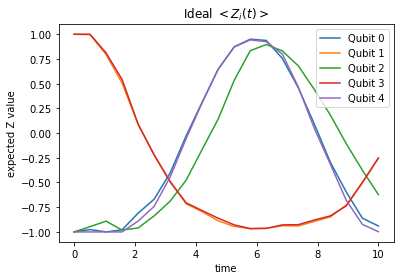

In [21]:
#Plot the mitigated results for each qubit
fig,ax = plt.subplots()
ax.plot(t, ideal_z_expval_dict[0], label='Qubit 0')
ax.plot(t, ideal_z_expval_dict[1], label='Qubit 1')
ax.plot(t, ideal_z_expval_dict[2], label='Qubit 2')
ax.plot(t, ideal_z_expval_dict[3], label='Qubit 3')
ax.plot(t, ideal_z_expval_dict[4], label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("Ideal $<Z_i(t)>$")
ax.legend()

In [22]:
#We want to compare this to the unmitigated counts, so we redefine the executor without
# any kind of readout error mitigation.
def qiskit_multiqubit_executor(circuit, shots: 2000, qubit) -> float:
#     noise_model = NoiseModel()
#     noise_model.add_all_qubit_quantum_error(
#         depolarizing_error(one_qubit_error, 1),
#         ["u1", "u2", "u3"],
#     )
#     noise_model.add_all_qubit_quantum_error(two_qubit_error, ['cx'])
    
    noise_model = NoiseModel.from_backend(backend)
    
    basis_gates = noise_model.basis_gates

    # execution of the experiment
    job = qiskit.execute(
        circuit,
        backend,
        basis_gates=basis_gates,
        # we want all gates to be actually applied,
        # so we skip any circuit optimization
        optimization_level=0,
        #noise_model=noise_model,
        shots=shots,
        seed_transpiler=1,
        seed_simulator=1
    )
    results = job.result()
    #mit_results = meas_filter.apply(results)
    counts = results.get_counts()
    prob = 0
    for x in counts.keys():
        #if (x[qubit] == '1') & (not post_selection(x)):
        if x[qubit] == '1':
            prob += counts[x] / shots
    return 2*prob - 1

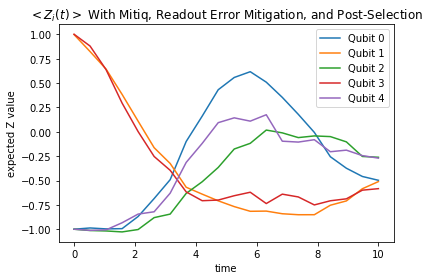

In [23]:
#Plot the mitigated results for each qubit
fig,ax = plt.subplots()
ax.plot(t, z_expval_dict[0], label='Qubit 0')
ax.plot(t, z_expval_dict[1], label='Qubit 1')
ax.plot(t, z_expval_dict[2], label='Qubit 2')
ax.plot(t, z_expval_dict[3], label='Qubit 3')
ax.plot(t, z_expval_dict[4], label='Qubit 4')
ax.set_xlabel('time')
ax.set_ylabel('expected Z value')
ax.set_title("$<Z_i(t)>$ With Mitiq, Readout Error Mitigation, and Post-Selection")
ax.legend()

In [24]:
unmit_expval = []

#Create a list for the 0th qubit for each time slice.
for x in range(0,len(Trotter_circuit)):
    unmit_expval.append(qiskit_multiqubit_executor(Trotter_circuit[x], 8192, 0))

unmit_expval

[-0.95751953125,
 -0.86083984375,
 -0.846435546875,
 -0.81201171875,
 -0.659423828125,
 -0.534423828125,
 -0.35986328125,
 -0.162353515625,
 0.00927734375,
 0.15966796875,
 0.239013671875,
 0.263427734375,
 0.24072265625,
 0.180419921875,
 0.09765625,
 0.002197265625,
 -0.09423828125,
 -0.158447265625,
 -0.1953125,
 -0.2109375]

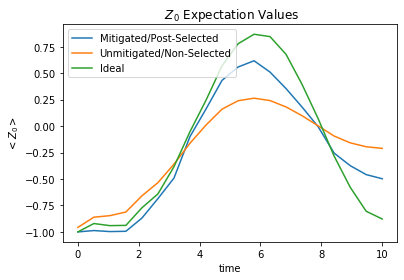

In [25]:
#Plot the expectation values for qubit 0, for the ideal, unmitigated, and mitigated results.
fig,ax = plt.subplots()
ax.plot(t, z_expval_dict[0], label='Mitigated/Post-Selected')
ax.plot(t, unmit_expval, label='Unmitigated/Non-Selected')
ax.plot(t, q0_sim_list, label='Ideal')
ax.set_xlabel('time')
ax.set_ylabel('$<Z_0>$')
ax.set_title(" $Z_0$ Expectation Values")
ax.legend()

1. Post selection: Validate result using the following,
$\sum_i n_i n_{i+1}$

$n_i = (I + Z_i)/2$

$\sum_i \langle n_i n_{i+1}(t) \rangle$

2. Talk to Noah about mitiq on real device

3. Play around with dt, see how large we can make it to keep first peak about the same

In [26]:
def n_i(Z_i):
    return (1 + Z_i)/2

ideal_z_expval_dict

{0: [-0.9999999996960691,
  -0.9762297356477989,
  -0.9999999999995679,
  -0.9789285846035741,
  -0.8101646672467993,
  -0.6689997212031842,
  -0.40276694266414537,
  -0.028032528998978457,
  0.31376370859265035,
  0.6460403236435077,
  0.8733776440181671,
  0.9500539955223377,
  0.9371934877543997,
  0.7556955326611734,
  0.45780895173760494,
  0.0910353279767766,
  -0.2950282259363085,
  -0.5979380667558616,
  -0.8610038388226836,
  -0.940368756530105],
 1: [0.9999999999743894,
  0.9955139427329753,
  0.7953829556567977,
  0.5055928708277897,
  0.0877207334947745,
  -0.22185210848869708,
  -0.487631980071104,
  -0.7159123748920921,
  -0.7959031594080829,
  -0.8877472941321786,
  -0.9449550917847536,
  -0.9664625049435659,
  -0.9638677698450626,
  -0.9384382053703815,
  -0.9397407546159445,
  -0.8936503590130339,
  -0.8483918277288844,
  -0.7282603416216508,
  -0.5049633569611371,
  -0.25275685898174094],
 2: [-0.9999999999999525,
  -0.9467072937254017,
  -0.8911555116467228,
  -0.980

In [27]:
n_i_dict = {}

for y in ideal_z_expval_dict:
    n_i_dict.update({y:[]})
    for x in ideal_z_expval_dict[y]:
        n_i_dict[y].append(n_i(x))

n_i_dict

{0: [1.5196544023154956e-10,
  0.011885132176100544,
  2.1604940059205546e-13,
  0.010535707698212937,
  0.09491766637660037,
  0.1655001393984079,
  0.2986165286679273,
  0.48598373550051077,
  0.6568818542963252,
  0.8230201618217539,
  0.9366888220090835,
  0.9750269977611689,
  0.9685967438771999,
  0.8778477663305867,
  0.7289044758688025,
  0.5455176639883883,
  0.35248588703184575,
  0.2010309666220692,
  0.0694980805886582,
  0.029815621734947506],
 1: [0.9999999999871947,
  0.9977569713664877,
  0.8976914778283989,
  0.7527964354138948,
  0.5438603667473872,
  0.38907394575565146,
  0.256184009964448,
  0.14204381255395393,
  0.10204842029595856,
  0.05612635293391072,
  0.027522454107623218,
  0.016768747528217054,
  0.018066115077468692,
  0.030780897314809263,
  0.030129622692027735,
  0.053174820493483044,
  0.07580408613555778,
  0.13586982918917462,
  0.24751832151943143,
  0.37362157050912953],
 2: [2.375877272697835e-14,
  0.026646353137299128,
  0.0544222441766386,
  

In [28]:
n_i_prod_dict = {}

for x in n_i_dict:
    n_i_prod_dict.update({x:[]})
    for i,y in zip(range(0,len(n_i_dict[x])),n_i_dict[x]):
        if x == 4:
            break
        n_i_prod_dict[x].append(y*n_i_dict[x+1][i])

n_i_prod_dict.pop(4)
n_i_prod_dict

{0: [1.519654402296036e-10,
  0.011858473484316472,
  1.9394570570142203e-13,
  0.00793124319977743,
  0.05162195684638403,
  0.06439179225884892,
  0.07650077975581317,
  0.06903098262970488,
  0.06703375555202,
  0.046193120074132066,
  0.025779975116868654,
  0.016349981558652495,
  0.017498780238546962,
  0.027020941953456466,
  0.021961616836457254,
  0.029007803858606747,
  0.026719870542130524,
  0.027314043096675206,
  0.017202048256126857,
  0.011139759418317225],
 1: [2.375877272667411e-14,
  0.026586584604233486,
  0.04885438480166468,
  0.007151768751902427,
  0.010826015046704688,
  0.03156369436405062,
  0.039871809443968974,
  0.037223046977416414,
  0.042615773012408674,
  0.03207145419296532,
  0.021113461877887253,
  0.01536968314171554,
  0.01712797530038266,
  0.028189575943362567,
  0.02531296028148915,
  0.03830696276490474,
  0.04480286485220656,
  0.060565572386238484,
  0.07723233308434557,
  0.07044797037239417],
 2: [2.3758772726978688e-14,
  0.02664635313736

In [29]:
sum_list = []

for x in range(0,len(n_i_prod_dict[0])):
    sum_list.append(n_i_prod_dict[0][x] + n_i_prod_dict[1][x] + n_i_prod_dict[2][x] + n_i_prod_dict[3][x])

sum_list

[1.5206302883346784e-10,
 0.06509141122597209,
 0.09812545293643973,
 0.022407632883799603,
 0.10321479085963865,
 0.1778995661449827,
 0.22604025096868005,
 0.21427580500645407,
 0.22491916129487868,
 0.17507611627056685,
 0.10755126659205663,
 0.06305461329693975,
 0.06904643870818197,
 0.11974316110006776,
 0.10474470762246565,
 0.14252112650311813,
 0.1471252060603978,
 0.16786836745413355,
 0.1824018201582166,
 0.15236609804384596]

No handles with labels found to put in legend.


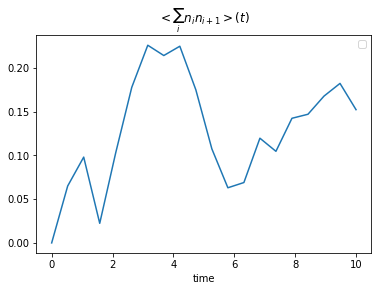

In [30]:
fig,ax = plt.subplots()
ax.plot(t, sum_list)
ax.set_title('$<\sum_i n_i n_{i+1}>(t)$')
ax.set_xlabel('time')
ax.legend()

In [31]:
def zero_str(num_zeros):
    zero_string = ''
    x = 0
    while x < num_zeros:
        zero_string = zero_string + '0'
        x += 1
    return zero_string

num_qubits = 5

num_bits=2**num_qubits
state_list = []

for x in range(0,num_bits):
    if x <= num_bits + 1:
        compare = len(bin(num_bits)[2:]) - len(bin(x)[2:])
        state_list.append(zero_str(compare-1) + bin(x)[2:])

for x in state_list:
    print(x, post_selection(x))

00000 False
00001 False
00010 False
00011 True
00100 False
00101 False
00110 True
00111 True
01000 False
01001 False
01010 False
01011 True
01100 True
01101 True
01110 True
01111 True
10000 False
10001 False
10010 False
10011 True
10100 False
10101 False
10110 True
10111 True
11000 True
11001 True
11010 True
11011 True
11100 True
11101 True
11110 True
11111 True


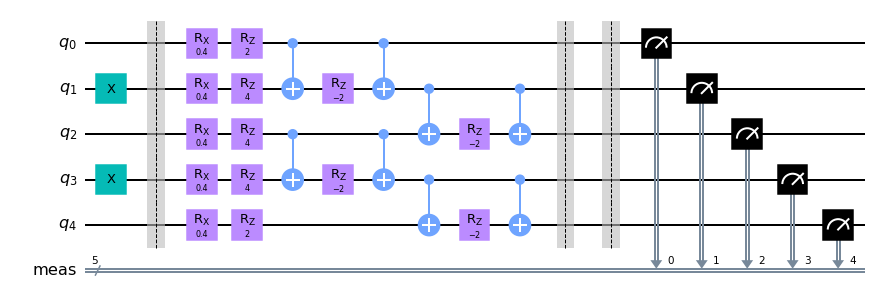

In [32]:
backend = qiskit.Aer.get_backend("qasm_simulator")
# backend = FakeVigo()

job = qiskit.execute(Trotter_circuit[1],backend,shots=8192)
results = job.result()
counts = results.get_counts()

Trotter_circuit[1].draw(output='mpl')

In [33]:
print(counts)

{'01001': 10, '11000': 13, '01010': 6707, '11010': 267, '01000': 292, '00010': 283, '01011': 275, '01110': 265, '00000': 9, '01100': 11, '11011': 11, '00110': 8, '11111': 1, '10010': 17, '00100': 2, '11110': 9, '01111': 4, '11001': 2, '10011': 2, '11100': 1, '00011': 2, '10110': 1}


In [34]:
qubit = 0

copy_counts = counts.copy()

total = []

for x in counts.keys():
    if post_selection(x):
        copy_counts.pop(x)
print(copy_counts)

for x in copy_counts:
    total.append(copy_counts[x])

total = sum(total)

one_counts = 0

for x in copy_counts.keys():
    if x[qubit] == '1':
        one_counts += copy_counts[x]

prob = one_counts / total
        
print(one_counts)
print(total)
print(one_counts / total)

{'01001': 10, '01010': 6707, '01000': 292, '00010': 283, '00000': 9, '10010': 17, '00100': 2}
17
7320
0.0023224043715846993


In [35]:
interested_states = []

for x in copy_counts.keys():
    if x[qubit] == '1':
        interested_states.append(copy_counts[x])

sum(interested_states)

17

In [36]:
def z1_prob(qubit):
    copy_counts = counts.copy()

    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    return one_counts / total

def z_expval(qubit):
    copy_counts = counts.copy()

    total = []

    for x in counts.keys():
        if post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    prob = one_counts / total
    return 2*prob - 1

In [37]:
z1_prob(0)

#(1 + z_expval(1))/2

0.0023224043715846993

In [38]:
n_i_list = []

for x in range(0,5):
    n_i_list.append(1 + z_expval(x)/2)

n_i_list

[0.5023224043715847,
 1.457513661202186,
 0.5002732240437158,
 1.45724043715847,
 0.5013661202185793]

In [39]:
for i in range(0,len(n_i_list)-1):
    print(z1_prob(i)*n_i_list[i+1]*n_i_list[i])

0.0017003292396026949
0.6981759295310164
0.00019918534746014797
0.6993703779119953


Bitstring: $n_i * n_{i+1} = 1/4 + 1/4(Z_i + Z_{i+1}) + 1/4(Z_i * Z_{i+1})$

Suppose $i = 0: Z_0|0...> = |0...>, Z_0|1...>  = -|1...>$

$<Z_0> = \sum_n \frac{<n| Z_0 |n>}{n}$ ($n$ is a bitstring measured in Z)